# Imports

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\3671978621.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Functions and Classes

In [2]:
class LogTransformer(TransformerMixin):
    def __init__(self, features: List[str]):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for feature in self.features:
            X[feature] = np.log(X[feature])
        return X
    
class FeatureRemoval(TransformerMixin):
    def __init__(self, features: List[str]):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.features, axis=1)

def create__general_lost_sum__over__general_limite_de_cred_sum(df: pd.DataFrame) -> pd.DataFrame:
    df['general_lost_sum__over__general_limite_de_cred_sum'] = df['general_lost_sum'] / df['general_limite_de_cred_sum']
    return df

def create__general_vencido_sum__over__general_limite_de_cred_sum(df: pd.DataFrame) -> pd.DataFrame:
    df['general_vencido_sum__over__general_limite_de_cred_sum'] = df['general_vencido_sum'] / df['general_limite_de_cred_sum']
    return df

class FeatureCreation(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = create__general_lost_sum__over__general_limite_de_cred_sum(X)
        X = create__general_vencido_sum__over__general_limite_de_cred_sum(X)
        return X
    
def evaluate_model(y_true, y_pred):

    # pr auc curve
    no_skill = len(y_true[y_true == 1]) / len(y_true)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'Baseline Model (area = {pr_auc:.2f})')
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill (area = {no_skill:.2f})')
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # roc auc curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label=f'no-skill (area = 0.50)')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

def evaluate_model_with_train(train_y_true, test_y_true, train_y_pred, test_y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    no_skill = len(train_y_true[train_y_true == 1]) / len(train_y_true)
    precision, recall, _ = precision_recall_curve(train_y_true, train_y_pred)
    pr_auc = auc(recall, precision)
    
    fig.suptitle('Train and Test Evaluation')
    ax[0].plot(recall, precision, label=f'Baseline Model (area = {pr_auc:.2f})')
    ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill (area = {no_skill:.2f})')
    ax[0].legend()
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Training Precision-Recall Curve')

    fpr, tpr, _ = roc_curve(train_y_true, train_y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label=f'no-skill (area = 0.50)')
    ax[1].legend()
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Training ROC Curve')
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    no_skill = len(test_y_true[test_y_true == 1]) / len(test_y_true)
    precision, recall, _ = precision_recall_curve(test_y_true, test_y_pred)
    pr_auc = auc(recall, precision)
    ax[0].plot(recall, precision, label=f'Baseline Model (area = {pr_auc:.2f})')
    ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill (area = {no_skill:.2f})')
    ax[0].legend()
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Test Precision-Recall Curve')

    fpr, tpr, _ = roc_curve(test_y_true, test_y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label=f'no-skill (area = 0.50)')
    ax[1].legend()
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Test ROC Curve')
    plt.show()

# Data ingestion

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')
all_data = pd.concat([train, test, valid])

# treatments applied to the training data (check EDA notebook for details)
train = train[train['general_a_vencer_weighted_periodo_div_pct_risco'] >= 0]

keys = ['fake_cnpj', 'date_reference']
target = 'TARGET_default_within_11m'

features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'cnt_declined_reasons',
    'days_since_oldest_board_member',
    'general_a_vencer_pct_risco',
    'general_a_vencer_weighted_periodo_div_pct_risco',
    'general_limite_de_cred_sum_pct_risco',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum_sum_pct_risco',
    'v204r_is_popular_domain',
    'v254r_cnt_board_memebers',
    'years_since_first_relationship',
    'general_limite_de_cred_sum',
    'general_lost_sum',
    'general_vencido_sum'
    ]

# features that may induce bias/information from other models


# Model pipeline

## Baseline model

In [4]:
baseline_model = Pipeline([
    ('model', LGBMClassifier())
])

all_columns = [c for c in train.columns if c not in keys + [target]]

baseline_model.fit(train[all_columns], train[target])
preds = baseline_model.predict_proba(test[all_columns])[:, 1]
train_preds = baseline_model.predict_proba(train[all_columns])[:, 1]

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8527
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


In [5]:
# Train
print('AUC:', roc_auc_score(train[target], train_preds))
print('Precision:', precision_score(train[target], train_preds > 0.5))
print('Recall:', recall_score(train[target], train_preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(train[target], train_preds > 0.5))
print(confusion_matrix(train[target], train_preds > 0.5, normalize='true'))

AUC: 0.9803460352307771
Precision: 0.932460953989025
Recall: 0.6453403447268478
Confusion Matrix:
[[22615   160]
 [ 1214  2209]]
[[0.99297475 0.00702525]
 [0.35465966 0.64534034]]


In [6]:
# Test
print('AUC:', roc_auc_score(test[target], preds))
print('Precision:', precision_score(test[target], preds > 0.5))
print('Recall:', recall_score(test[target], preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(test[target], preds > 0.5))
print(confusion_matrix(test[target], preds > 0.5, normalize='true'))

AUC: 0.8286745773808186
Precision: 0.558303886925795
Recall: 0.17201959716929777
Confusion Matrix:
[[15733   250]
 [ 1521   316]]
[[0.98435838 0.01564162]
 [0.8279804  0.1720196 ]]


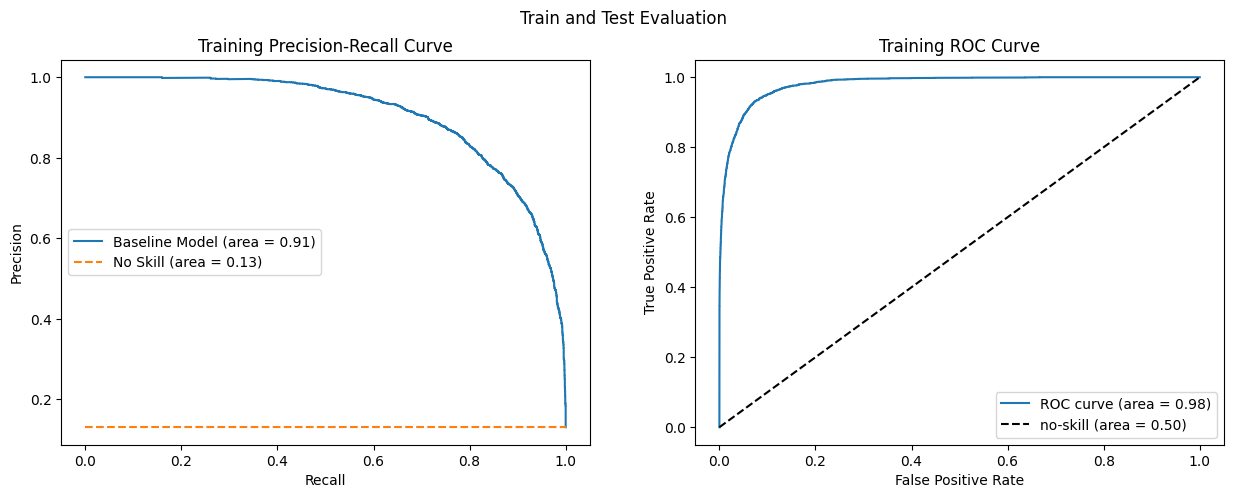

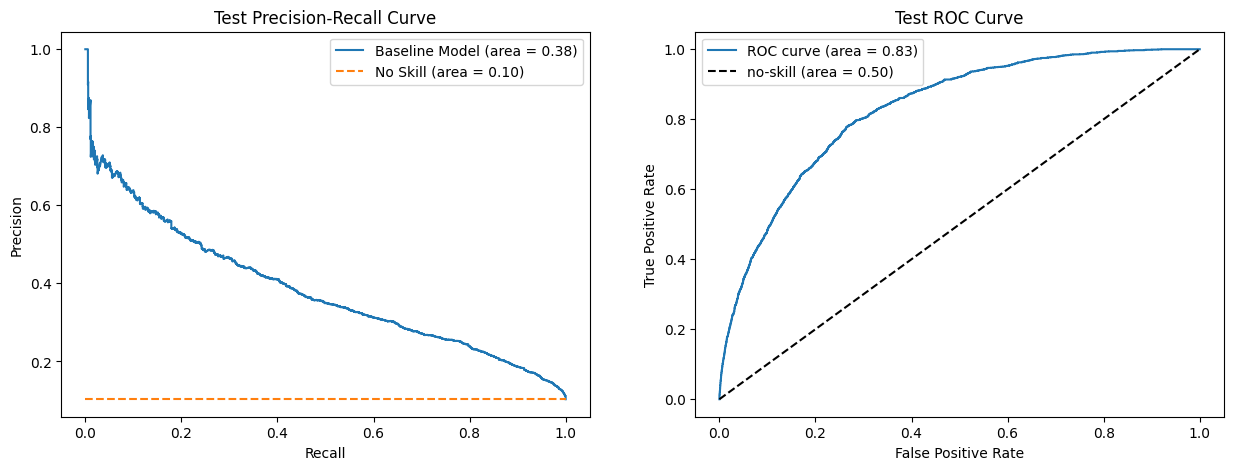

In [7]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

## Model with reduced feature set

In [8]:
log_transform_features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'general_limite_de_cred_sum',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_lost_sum',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum',
    'general_vencido_sum_sum_pct_risco']

model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('lgbm', LGBMClassifier(num_leaves=11, random_state=123))
])

model.fit(train[features], train[target])
preds = model.predict_proba(test[features])[:, 1]
train_preds = model.predict_proba(train[features])[:, 1]

c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] = df['general_lost_sum'] / df['general_limite_de_cred_sum']
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_vencido_sum__over__general_limite_de_cred_sum'] = df['general_vencido_sum'] / df['general_limite_de_cred_sum']


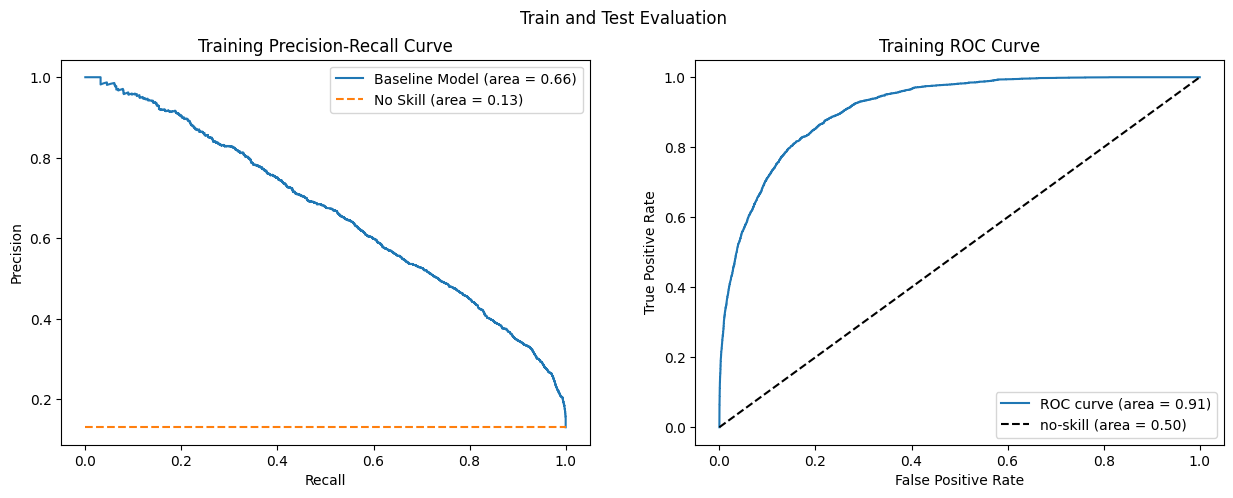

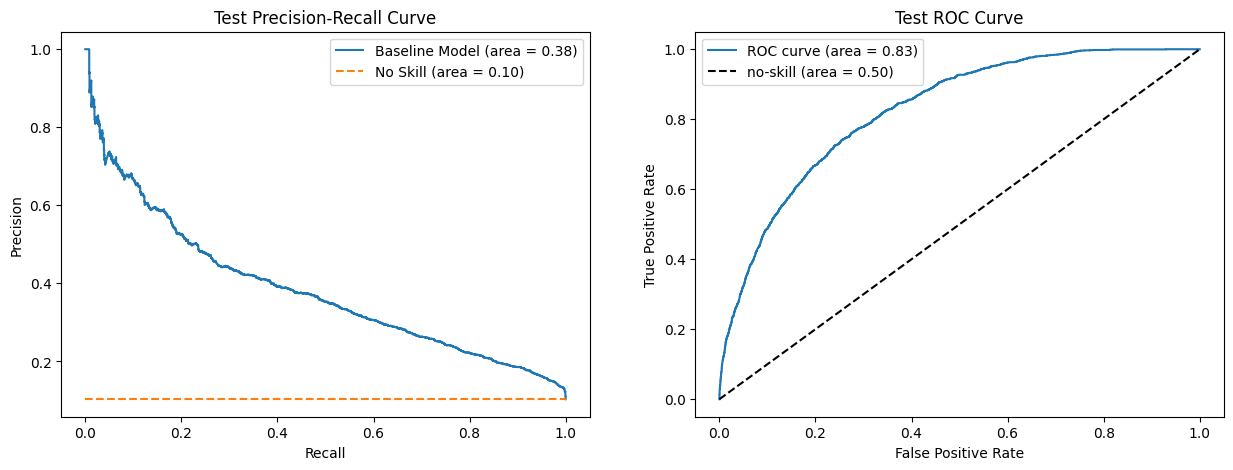

In [9]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

In [10]:
baseline_importances = pd.DataFrame(baseline_model[0].feature_importances_, index=all_columns, columns=['importance']).sort_values('importance', ascending=False)
new_importances = pd.DataFrame(model[3].feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

In [11]:
baseline_importances.join(new_importances, how='outer', lsuffix='_baseline', rsuffix='_new').fillna(0).sort_values('importance_baseline', ascending=False)

,importance_baseline,importance_new
years_since_first_relationship,242,136.0
v001r_social_capital,222,0.0
days_since_oldest_board_member,201,105.0
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,196,117.0
avg_final_numeric_prediction_prev_6mo,188,0.0
min_lt_ir3_prev_6mo,171,0.0
risco_total,125,0.0
general_limite_trend_6mo,117,61.0
general_a_vencer_over180d,116,0.0
primary_median_ir3_prev_6mo,111,0.0


In [12]:
# Altough some relevant features for the training dataset were removed in our EDA filter,
# the model still performs well in the test dataset

# Hyperparameter optimization

In [13]:
import optuna

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 31),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 123
    }
    model = Pipeline([
        ('log_transform', LogTransformer(log_transform_features)),
        ('create_features', FeatureCreation()),
        ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
        ('lgbm', LGBMClassifier(**param))
    ])
    model.fit(train[features], train[target])
    preds = model.predict_proba(test[features])[:, 1]
    return roc_auc_score(test[target], preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_params


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-02-04 23:42:08,299] A new study created in memory with name: no-name-2c160871-ca3b-4741-843c-9103d36855d7
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146
[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[Lig

C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146
[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146
[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[Lig

C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 0.6),
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\1617622482.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.8),
C:\Users\n

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

{'num_leaves': 15,
 'learning_rate': 0.04169101636627297,
 'n_estimators': 169,
 'min_child_samples': 92,
 'subsample': 0.11471938336421356,
 'colsample_bytree': 0.7728496355239205,
 'reg_alpha': 0.6026689061605318,
 'reg_lambda': 0.1336262802759424}

In [14]:
best_params = study.best_params

# {'num_leaves': 21,
#  'learning_rate': 0.017454587048769486,
#  'n_estimators': 254,
#  'min_child_samples': 67,
#  'subsample': 0.9072183112847305,
#  'colsample_bytree': 0.44710156894838227,
#  'reg_alpha': 0.00040566557595567,
#  'reg_lambda': 0.2197724860589774}

In [15]:
optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('lgbm', LGBMClassifier(**best_params))
])

optimal_model.fit(train[features], train[target])
preds = optimal_model.predict_proba(test[features])[:, 1]
train_preds = optimal_model.predict_proba(train[features])[:, 1]

c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

[LightGBM] [Info] Number of positive: 3423, number of negative: 22775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 26198, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130659 -> initscore=-1.895146
[LightGBM] [Info] Start training from score -1.895146


c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = np.log(X[feature])
C:\Users\nbeha\AppData\Local\Temp\ipykernel_11428\2167759532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['general_lost_sum__over__general_limite_de_cred_sum'] =

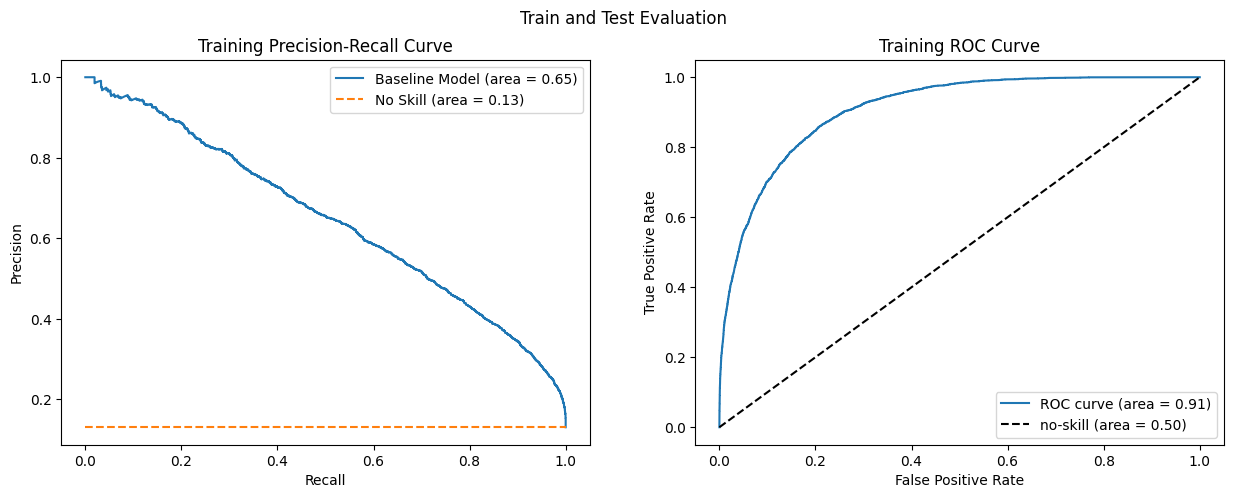

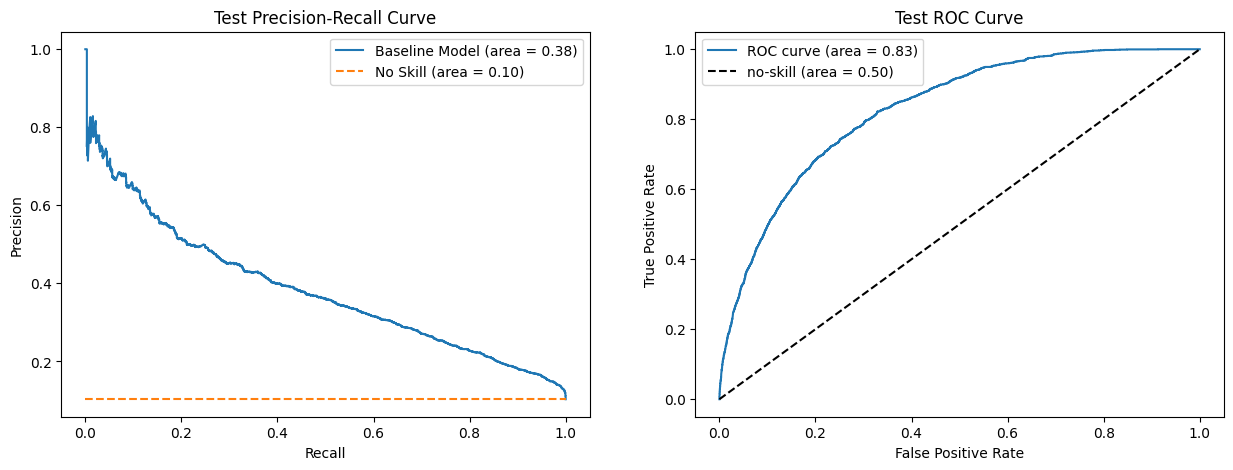

In [16]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

# SHAP Analysis

In [17]:
pd.DataFrame(optimal_model[3].feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

,importance
years_since_first_relationship,362
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,287
general_limite_de_cred_sum,199
days_since_oldest_board_member,197
chk_esp_cred_rot_a_vencer_pct_risco,159
general_a_vencer_weighted_periodo_div_pct_risco,155
general_limite_trend_6mo,148
general_a_vencer_pct_risco,128
general_limite_de_cred_sum_pct_risco,118
general_vencido_max_prev_6mo,110


In [18]:
import shap
explainer = shap.TreeExplainer(optimal_model[3])
shap_values = explainer.shap_values(test[features])


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


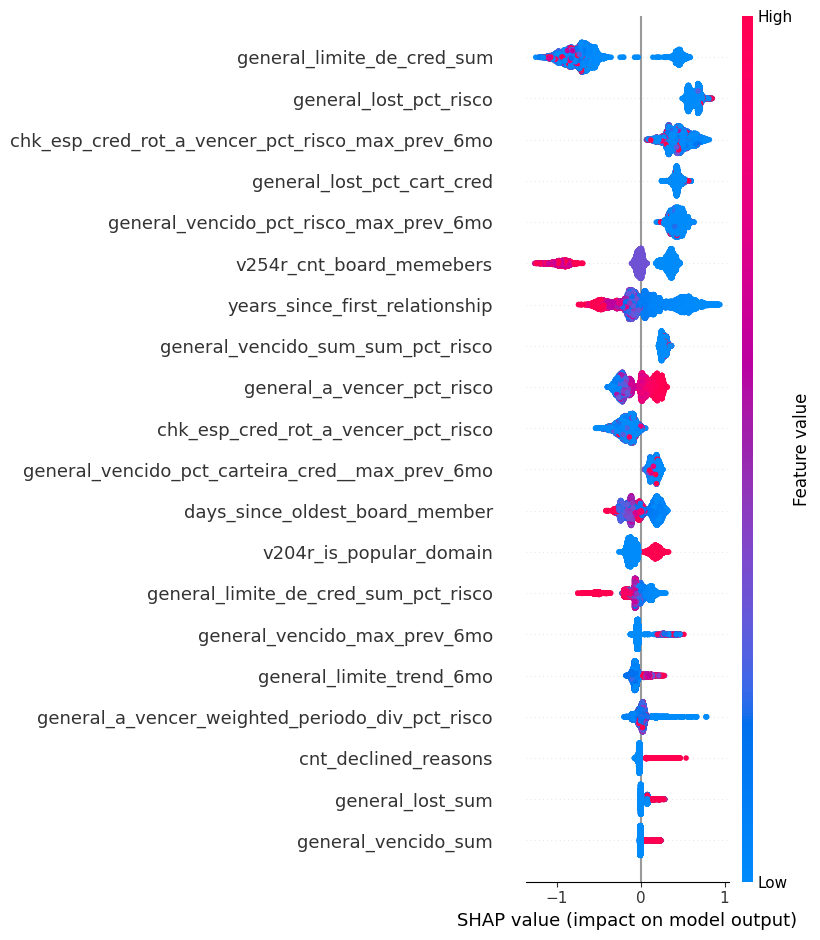

In [19]:
shap.summary_plot(shap_values[1], test[features])

# Time-based Evaluation

divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


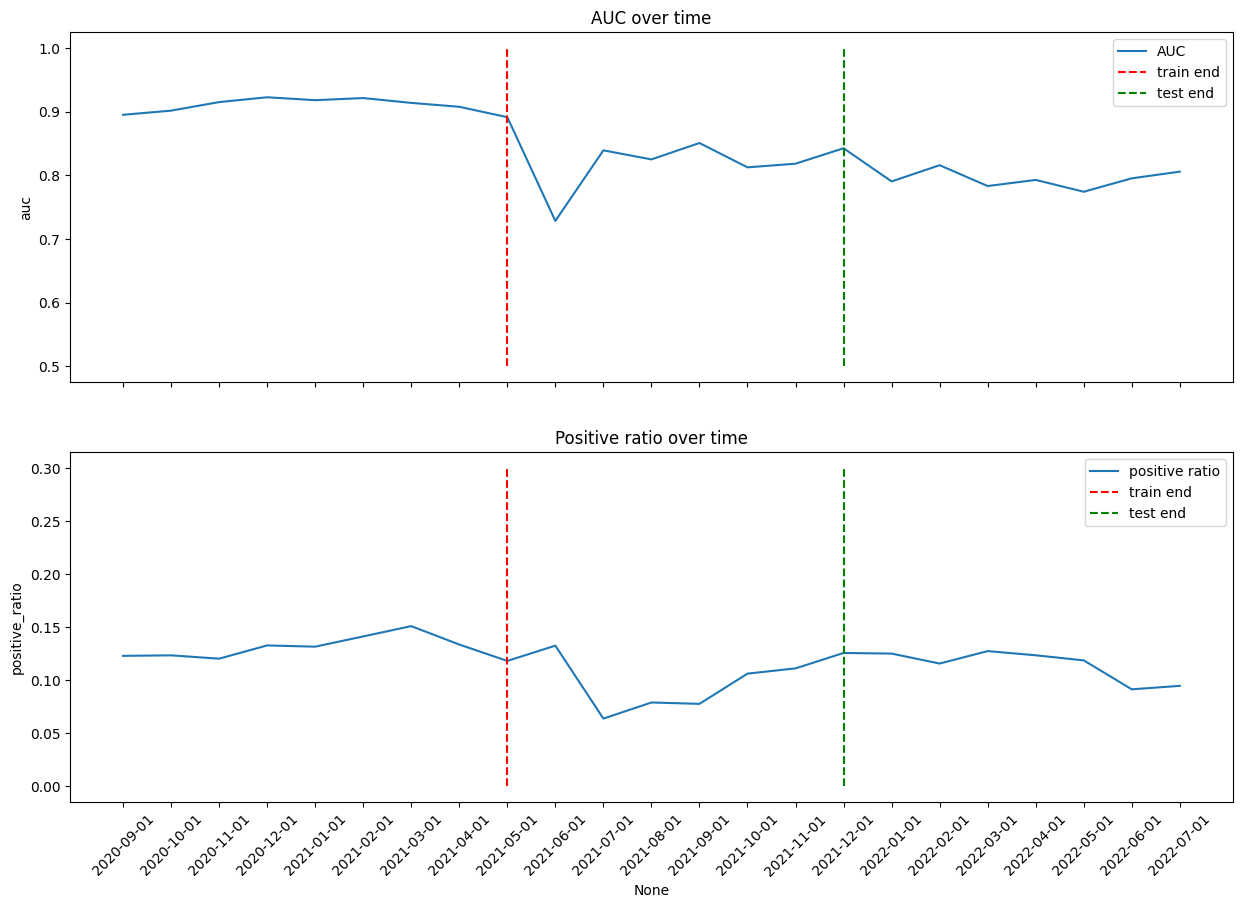

In [20]:
def time_based_evaluation(scored_df, date_col):
    score_dict = {}
    for date in sorted(scored_df[date_col].unique()):
        auc = roc_auc_score(scored_df[scored_df[date_col] == date][target], scored_df[scored_df[date_col] == date]['preds'])
        positive_instances = len(scored_df[scored_df[date_col] == date][scored_df[scored_df[date_col] == date][target] == 1])
        negative_instances = len(scored_df[scored_df[date_col] == date][scored_df[scored_df[date_col] == date][target] == 0])
        positive_ratio = positive_instances / (positive_instances + negative_instances)
        score_dict[date] = {'auc': auc,
                            'positive_instances': positive_instances,
                            'negative_instances': negative_instances,
                            'positive_ratio': positive_ratio}
        
    return pd.DataFrame(score_dict).T

all_data['preds'] = optimal_model.predict_proba(all_data[features])[:, 1]
scored_df = time_based_evaluation(all_data, 'date_reference')

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.lineplot(x=scored_df.index, y=scored_df['auc'], label='AUC', ax=ax[0])
ax[0].set_title('AUC over time')
ax[0].vlines(x=train['date_reference'].max(), ymin=0.5, ymax=1, color='r', linestyle='--', label='train end')
ax[0].vlines(x=test['date_reference'].max(), ymin=0.5, ymax=1, color='g', linestyle='--', label='test end')
ax[0].legend()

sns.lineplot(x=scored_df.index, y=scored_df['positive_ratio'], label='positive ratio', ax=ax[1])
ax[1].set_title('Positive ratio over time')
ax[1].vlines(x=train['date_reference'].max(), ymin=0, ymax=.3, color='r', linestyle='--', label='train end')
ax[1].vlines(x=test['date_reference'].max(), ymin=0, ymax=.3, color='g', linestyle='--', label='test end')
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)

plt.show()